In [1]:
import numpy as np
import ot
import os
import matplotlib.pyplot as plt
import torch
from MNISTDigitDataset import MNISTDigitDataset
from torchvision import transforms
from utils import plot_pca_for_arrays, plot_images_from_datasets, visualize_barycenter_diracs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: {}'.format(device))

/Users/balazsmorvay/anaconda3/envs/fmri_classifier/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/balazsmorvay/anaconda3/envs/fmri_classifier/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /Users/balazsmorvay/anaconda3/envs/fmri_classifier/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <9C467D80-5BAC-3156-B480-F0FF7E45DEF2> /Users/balazsmorvay/anaconda3/envs/fmri_classifier/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Using device: cpu


# Data setup

In [2]:
target_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        ])
target_transform_jitter=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomRotation(degrees=(45, 135))
        ])


ds_4 = MNISTDigitDataset(root='/Users/balazsmorvay/PycharmProjects/fmri_classifier/Data/MNIST/raw',
                         train=True,
                         download=True,
                         transform=target_transform,
                         digit=6)
ds_2 = MNISTDigitDataset(root='/Users/balazsmorvay/PycharmProjects/fmri_classifier/Data/MNIST/raw',
                         train=True,
                         download=True,
                         transform=target_transform,
                         digit=2)
ds_4jr = MNISTDigitDataset(root='/Users/balazsmorvay/PycharmProjects/fmri_classifier/Data/MNIST/raw',
                         train=True,
                         download=True,
                         transform=target_transform_jitter,
                         digit=6)
ds_2jr = MNISTDigitDataset(root='/Users/balazsmorvay/PycharmProjects/fmri_classifier/Data/MNIST/raw',
                         train=True,
                         download=True,
                         transform=target_transform_jitter,
                         digit=2)

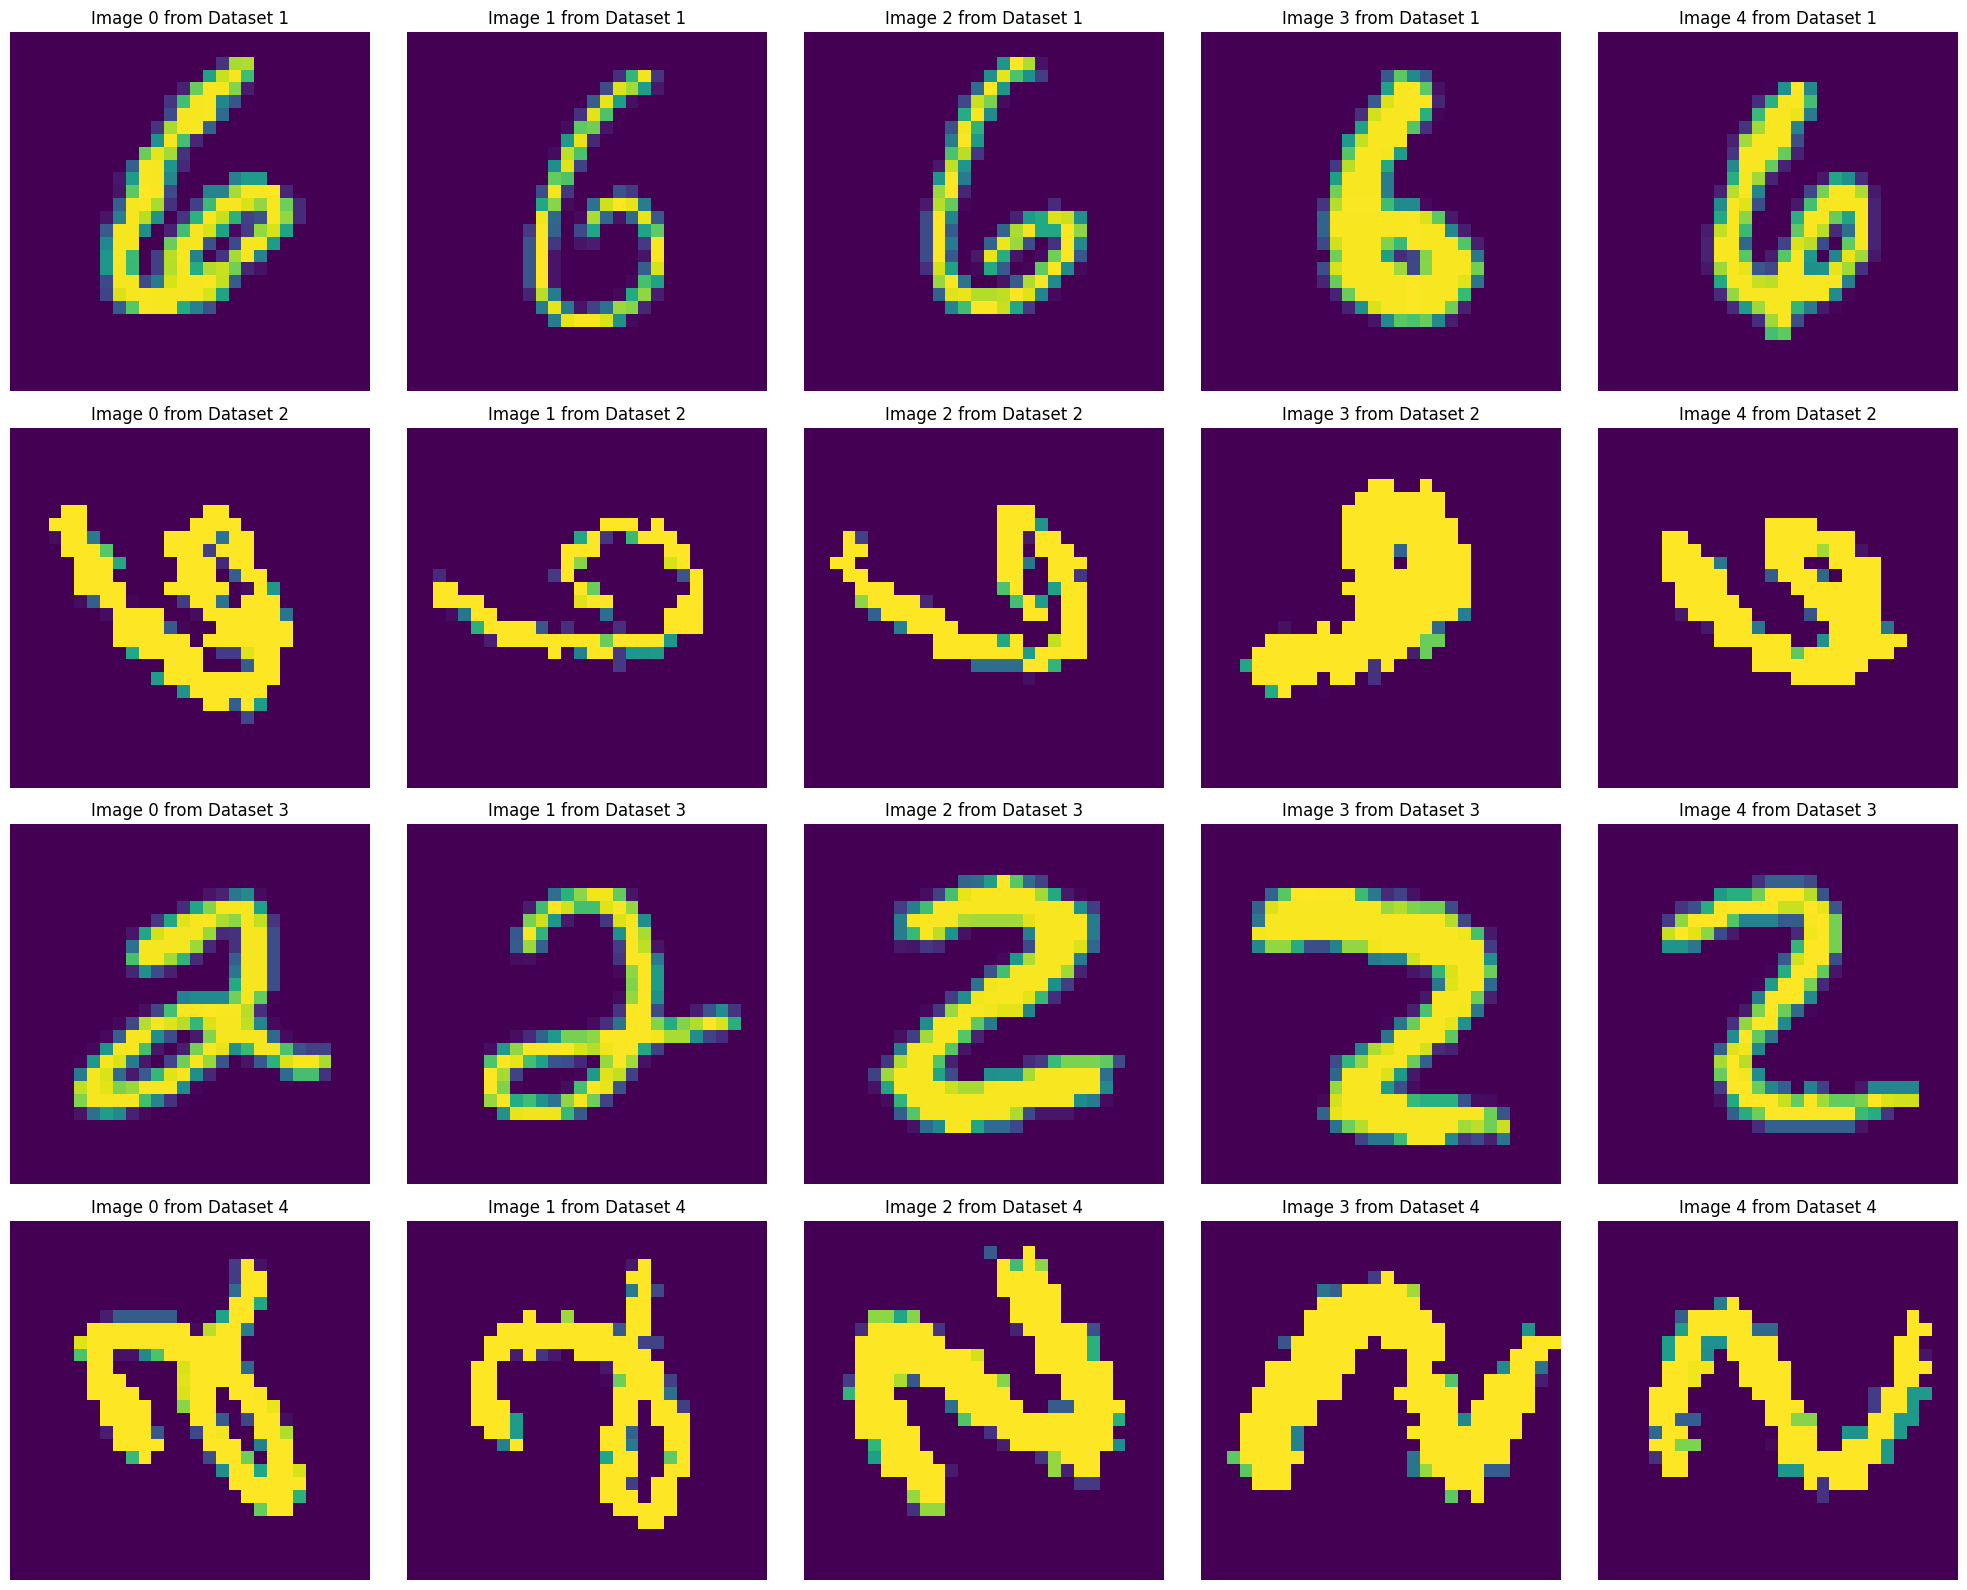

<Figure size 640x480 with 0 Axes>

In [3]:
plot_images_from_datasets(datasets=[ds_4, ds_4jr, ds_2, ds_2jr], num_images=5)

We now consider measures. Each dataset will be considered a measure:

$\mu = \sum a_i \delta_{xi}$

meaning that every image in the dataset is a dirac delta at point $x$, with probability mass of $a_i$. $x$ is the location of the dirac, and it has the coordinates of the flattened image. 

In [4]:
ds_2.__len__(), ds_4.__len__(), ds_2jr.__len__(), ds_4jr.__len__()

(5958, 5918, 5958, 5918)

Lets chose a training set of 1000 images from each dataset

In [5]:
n_samples = 1000
indices = np.arange(n_samples, dtype=int)

# Take the images
X_2 = np.array(ds_2.__getitem__(indices)[0])
X_4 = np.array(ds_4.__getitem__(indices)[0])
X_2jr = np.array(ds_2jr.__getitem__(indices)[0])
X_4jr = np.array(ds_4jr.__getitem__(indices)[0])

In [6]:
X_2.shape, X_4.shape, X_2jr.shape, X_4jr.shape

((1000, 784), (1000, 784), (1000, 784), (1000, 784))

Set the probability masses to uniform 1/n

In [7]:
a_i = 1.0 / n_samples
w_i = np.ones(shape=(n_samples,)) * a_i

Visualize the principal components of the datasets

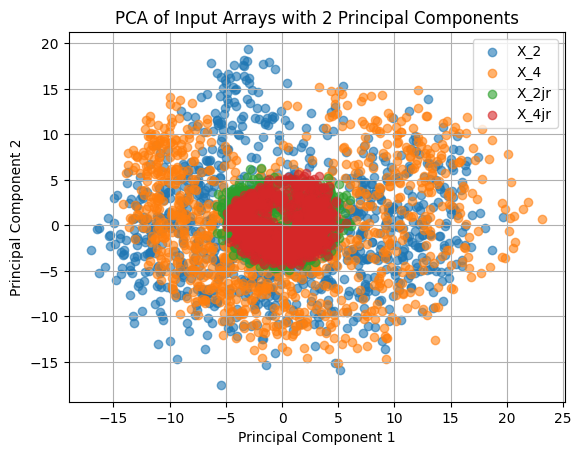

In [41]:
plot_pca_for_arrays(arrays=[X_2, X_4, X_2jr, X_4jr],
                    n_components=2,
                    labels=['X_2', 'X_4', 'X_2jr', 'X_4jr'])
plt.show()

# Compute the free-support Sinkhorn barycenter of the measures

In [9]:
recompute = False

if not recompute and os.path.exists('barycenter.npy'):
    barycenter = np.load('barycenter.npy')
else:
    barycenter = ot.bregman.free_support_sinkhorn_barycenter(
        measures_locations=[X_2, X_4, X_2jr, X_4jr],
        measures_weights=[w_i, w_i, w_i, w_i],
        X_init=np.random.randn(n_samples, X_2.shape[1]),
        reg=3.0,
        numItermax=2000,
        numInnerItermax=1000,
        verbose=True,
        stopThr=1e-7
    )
    # Save barycenter if kernel needs to be restarted
    np.save('barycenter.npy', barycenter)

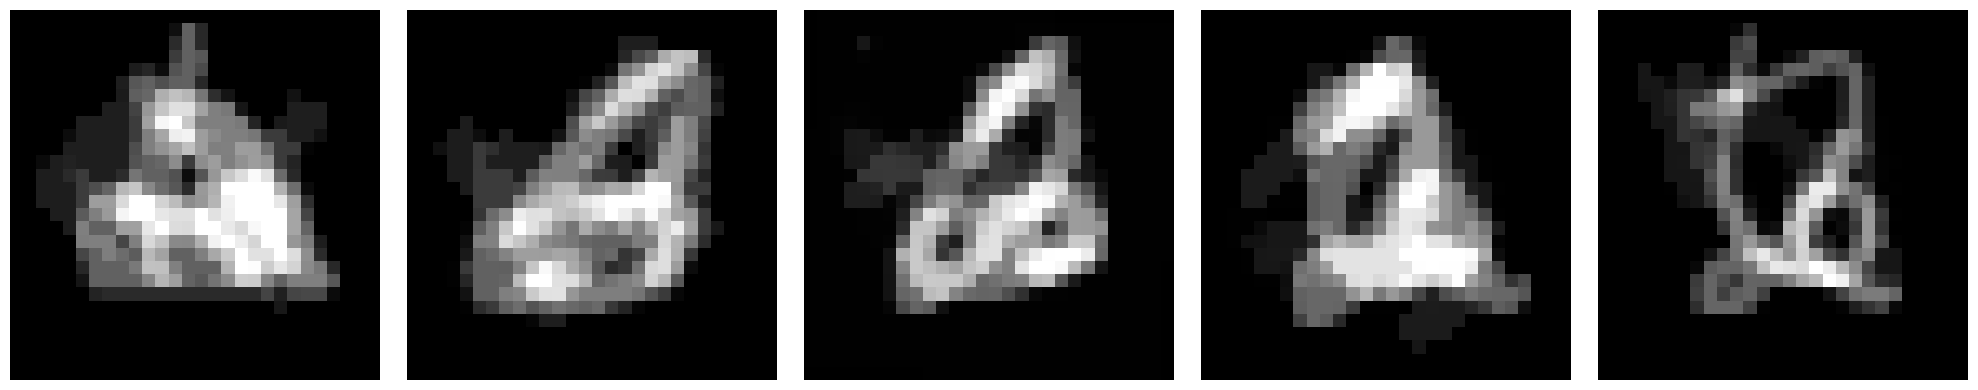

In [10]:
visualize_barycenter_diracs(barycenter=barycenter, num_images=5)

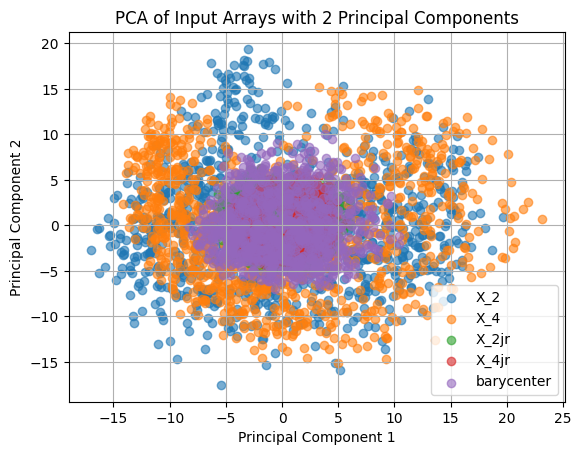

In [40]:
plot_pca_for_arrays(arrays=[X_2, X_4, X_2jr, X_4jr, barycenter],
                    n_components=2,
                    labels=['X_2', 'X_4', 'X_2jr', 'X_4jr', "barycenter"])
plt.show()

# Compute the Kantorovich and Monge solutions jointly
From the different measures to the barycenter.

- Kantorovich: One measure has 1000 dirac deltas at positions $x_i \in \mathbb{R}^{784}$, therefore the coupling matrices have shape $784 \times 784$.
- Monge: The map T is to be found as a linear transformation (represented by matrix $L \in \mathbb{R}^{784 \times 784}$) with a bias term (which makes it a matrix $\mathbb{R}^{785 \times 784}$).

In [13]:
G, L = ot.da.joint_OT_mapping_linear(xs=torch.tensor(X_2, dtype=torch.float, device=device),
                                     xt=torch.tensor(barycenter, dtype=torch.float, device=device),
                                     mu=1.0,
                                     eta=3e-2,
                                     bias=True,
                                     verbose=True,
                                     verbose2=False,
                                     numItermax=1000,
                                     numInnerItermax=1000,
                                     stopInnerThr=1e-10,
                                     stopThr=1e-5,
                                     log=False)

It.  |Loss        |Delta loss
--------------------------------
    0|3.756875e+05|0.000000e+00
    1|3.755914e+05|-2.557811e-04
    2|3.755806e+05|-2.878794e-05
    3|3.755792e+05|-3.660999e-06


In [36]:
G.shape, L.shape

(torch.Size([1000, 1000]), torch.Size([785, 784]))

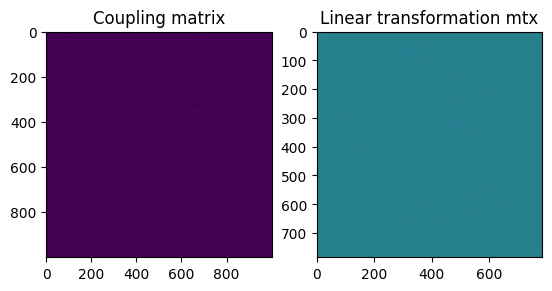

In [31]:
fig, axarr = plt.subplots(1, 2)
axarr[0].imshow(G)
axarr[0].set_title('Coupling matrix')
axarr[1].imshow(L)
axarr[1].set_title('Linear transformation mtx')
plt.show()

In [37]:
X_2_T = (torch.tensor(X_2, dtype=torch.float, device=device) @ L[0:784] + L[784])

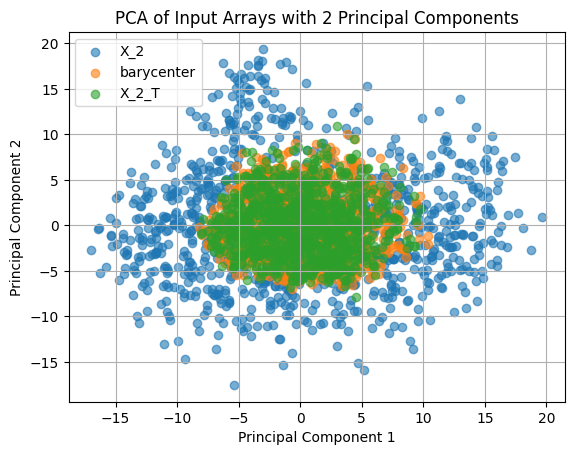

In [39]:
plot_pca_for_arrays(arrays=[X_2, barycenter, X_2_T],
                    n_components=2,
                    labels=['X_2', "barycenter", "X_2_T"])
plt.show()